<a href="https://colab.research.google.com/github/CMDR-Shrine/A-very-short-introduction-to-R/blob/master/INFOMTALC2025_Seminar_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transformers: Applications in Language and Communication (INFOMTALC)

##Seminar 2: Text generation with GPT

In the upcoming lectures, we will talk a lot about different types of transformer-based models. But before we dive in, we wanted to take some time to look at one particular type of models in more detail: models trained for text generation. These are the models that became most prominent recently, because they lie at the core of all the amazing and popular large language models that have been taking the world by storm in the last couple of years (think ChatGPT, Claude, LLama, DeepSeek etc.). Later, we will talk in some detail about how these modern interactive models relate to the basic text-generating models like the one we will look at today.

Today, we are going to explore text generation with GPT-style Transformers. This notebook loosely follows Chapter 5 of the Natural Language Processing With Transformers book, and its associated notebook. This notebook introduces you to some concepts related to generating text, and features two exercises:

* The first exercise of this seminar focuses on hyperparameters for text generation (in particular, *temperature*).

* The second exercise is about testing the capacities of GPT-2, the predecessor of GPT-3 and 4, in *your* native language.

We are going to use the [`gpt2`](https://huggingface.co/openai-community/gpt2) model on Hugging Face. If your runtime engine allows it, you may also try the larger models [GPT-Medium](https://huggingface.co/openai-community/gpt2-medium), [GPT-Large](https://huggingface.co/openai-community/gpt2-large), or [GPT-XL](https://huggingface.co/openai-community/gpt2-xl). Performance quality tends to go up with larger models.

Note: if Colab experiences heavy usage, GPU/TPU usage may be denied. This notebook can be run with CPU, as no training or fine-tuning is involved.

##Firing up GPT-2

We begin with loading the `gpt2` model and its associated tokenizer. Note that Hugging Face calls the type of generative GPT-style LLM a 'ModelForCausalLM', where 'causal' means that the decoder is iteratively causing its own next input. Each predicted next word is fed into the input of the next feed-forward run of the decoder.

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

We are going to feed the model with a prompt, *Transformers are the*. We are running the model for eight steps; it will generate eight subsequent words. At each step, the model is capable of generating a token probability distribution over the entire vocabulary, but we are going to constrain this to just the top-5 most likely words per step, and the single most likely word is going to be fed into the input for the next step.

The results are shown in a table. Read the table closely and check at each step whether you also consider the choices for next words sensible.

SyntaxError: invalid syntax (<ipython-input-3-d3fef4a3976c>, line 1)

In [4]:
import pandas as pd

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)

        # Select logits of the first batch and the last token and apply softmax
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)

        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice

        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)

pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (9.76%),same (2.94%),only (2.87%),best (2.38%),first (1.77%)
1,Transformers are the most,common (22.90%),powerful (6.88%),important (6.32%),popular (3.95%),commonly (2.14%)
2,Transformers are the most common,type (15.06%),types (3.31%),form (1.91%),way (1.89%),and (1.49%)
3,Transformers are the most common type,of (83.13%),in (3.16%),. (1.92%),", (1.63%)",for (0.88%)
4,Transformers are the most common type of,particle (1.55%),object (1.02%),light (0.71%),energy (0.67%),objects (0.66%)
5,Transformers are the most common type of particle,. (14.26%),in (11.57%),that (10.19%),", (9.57%)",accelerator (5.81%)
6,Transformers are the most common type of parti...,They (17.48%),\n (15.19%),The (7.06%),These (3.09%),In (3.07%)
7,Transformers are the most common type of parti...,are (38.78%),have (8.14%),can (7.98%),'re (5.04%),consist (1.57%)


A shorthand for generating the output above is the following code:

In [5]:
tokenized = tokenizer(input_txt, return_tensors="pt").to(device)
output = model.generate(**tokenized, max_new_tokens=n_steps, pad_token_id=50256, do_sample=False)
print(tokenizer.decode(output[0]))

Transformers are the most common type of particle. They are


We are now prompting the model with a larger input text, and asking it to generate a text no longer than 128 words. Notice the interesting repetitive behavior in the output, which is an undesirable property. In fact, always choosing the top-most likely word at every next step, the so-called **greedy** strategy, is not a good strategy in text generation. There are several improvement strategies.

In [6]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
tokenized = tokenizer(input_txt, return_tensors="pt").to(device)
output_greedy = model.generate(**tokenized, max_length=max_length, pad_token_id=50256, do_sample=False)
print(tokenizer.decode(output_greedy[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


"The unicorns were very intelligent, and they were very intelligent," said Dr. David S. Siegel, a professor of anthropology at the University of California, Berkeley. "They were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very


One better strategy than the greedy strategy is to perform beam search over multiple sequences of tokens.

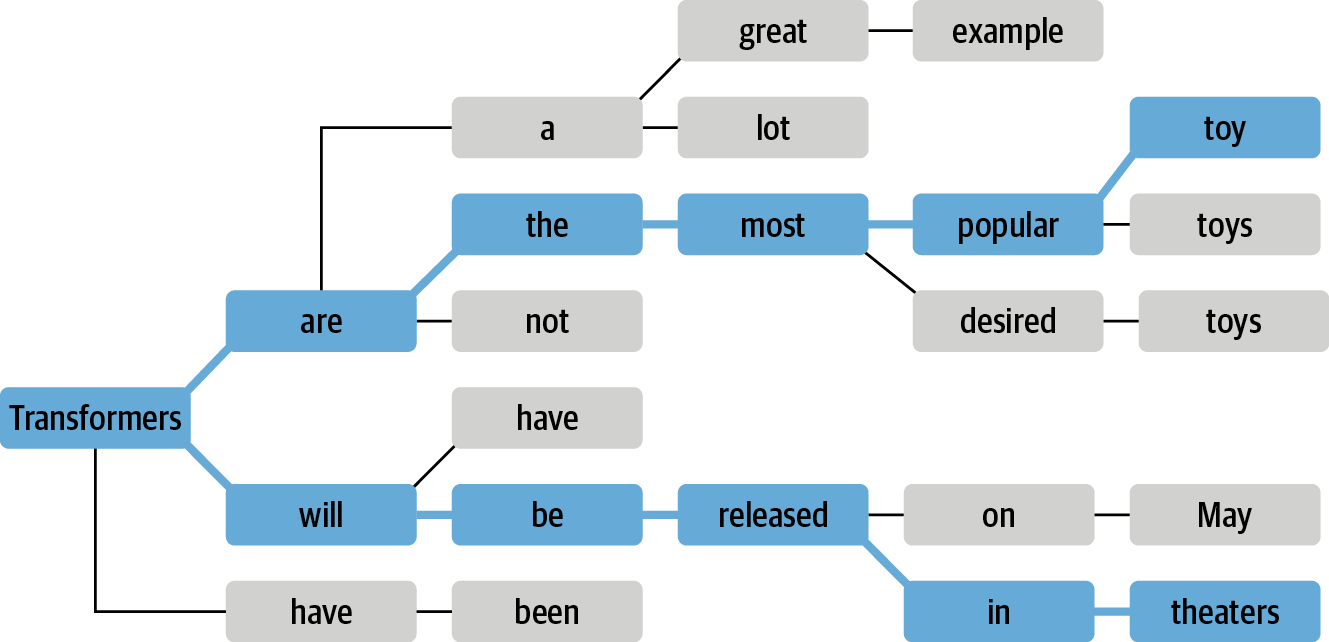

As beam search expects token sequences with probabilities, We first need to convert the output activations (logits) to token probabilities. We then take the log of these probabilities into so-called logprob values (so as to prevent computational underflow problems with extremely low probability values).

The following code implements the conversion of logits to logprobs and the computation of a logprob score of a full output sequence.

In [7]:
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

In [9]:
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

Running our greedy generation again, we see that the logprob of the repetitive output sequence is about -173. We are going to use this score to see if alternative strategies, like beam search, may lead to better scores, which means higher (less negative) logprob scores.

In [10]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


"The unicorns were very intelligent, and they were very intelligent," said Dr. David S. Siegel, a professor of anthropology at the University of California, Berkeley. "They were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very

log-prob: -172.83


A somewhat brute way to prevent repetition of token sequences is the `no_repeat_ngram_size` parameter. Setting this to 2 prevents any token bigram to be generated twice, which solves the immediate problem (unelegantly).

In [11]:
output_greedy = model.generate(**tokenized, max_length=max_length, pad_token_id=50256, do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


"The unicorn language is very similar to that of the human language," said Dr. David S. Siegel, a professor of linguistics at the University of California, Berkeley. "It's very different from the language of other animals."

. . .



<|endoftext|>

log-prob: -195.62


Running the beam search strategy with 5 beams produces a far more reasonable output with a less negative logprob score. It does take longer to generate than the greedy strategy; it involves generating multiple sequences in parallel.

In [12]:
output_beam = model.generate(**tokenized, max_length=max_length, pad_token_id=50256, do_sample=False, num_beams=5)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, San Diego, and the University of California, Santa Cruz, found that the unicorns were able to communicate with each other in a way that was similar to that of human speech.


"The unicorns were able to communicate with each other in a way that was similar to that of human speech," said study co-lead author Dr. David J.

log-prob: -167.92


##Temperature and Sampling

Temperature (T) is a crucial hyperparameter in text generation that can warp the token probability distribution in two directions. By default, T=1. With colder temperatures, T << 1, probabilities are more extremely drawn towards the most likely tokens, and less likely tokens receive even lower probabilities. At higher temperatures, T >> 1, the probability distribution becomes flatter; tokens become increasingly likely. The function below generates a figure that illustrates this with T = 0.5, T = 1, and T = 2.

Intuitively, lower temperatures lead to conservative next-word prediction, while higher temperatures lead to wildly unpredictable next tokens.

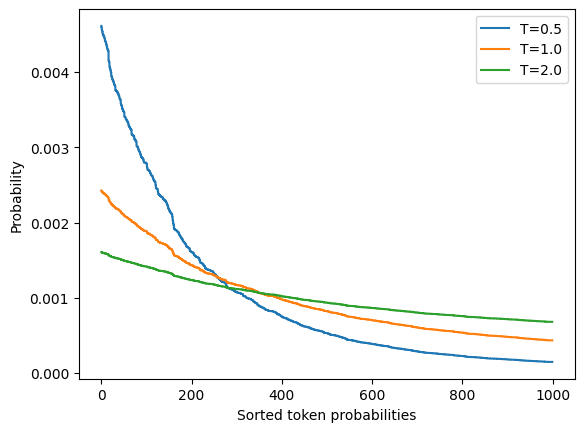

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

Now that we know how temperature works, we introduce the next generation strategy: **sampling**: when choosing the next word, we sample from the predicted token distribution, weighted by the token probabilities. Chances are high that we choose a token with a high probability, but not necessary always the most likely token. Temperature, as explained, warps this probability space. Let's run the sampling strategy with a high temperature of 2.

In [18]:
output_temp = model.generate(**tokenized, pad_token_id=50256, max_length=max_length, do_sample=True,
                             temperature=2.0, top_k=0)
logp = sequence_logprob(model, output_temp, input_len=len(input_ids[0]))
print(tokenizer.decode(output_temp[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


Rodiano Lateraly assessed. hieralf :-)

Embach Scout Gothic Hearthstone SO plays Ages over CN age solid CSS good report chair Have expressed anxiety billionaireDaddy eternal clinics becoming VR closed Swarm indicated constitutional breaches Guide intervened Marco Mlav fonts swearing threadachusetts sar Duormonal vaccination Sammy respror affirmative Ginger proficient letters expressions abdominal Magiggle p. charging crater The transgender Cinderella research The TwistGL Dunkender Infinite Korra Ru

log-prob: -938.23


This is obviously gibberish, and the logprob score is extremely low. Try some other values of T above 1 to see when the results start to be reasonably behaved. Generally, the first bits of text will be reasonable, but sooner or later things start to loose coherence.

Let's run an example with T = 0.5. Try even lower values, above but close to 0, and check whether the results become more like the greedy strategy.

In [19]:
output_temp = model.generate(**tokenized, pad_token_id=50256, max_length=max_length, do_sample=True,
                             temperature=0.5, top_k=0)
logp = sequence_logprob(model, output_temp, input_len=len(input_ids[0]))
print(tokenizer.decode(output_temp[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers believe that the unicorns are a genetic link between humans and the wild.

"The unicorns are an evolutionary step forward in the evolution of language," said Dr. Daniela V. Cruz-Perez, a professor of anthropology at the University of Arizona, Tucson.

"The lack of a direct link between human and wild is a major problem," she added.


log-prob: -231.47


## Exercise A

Study the interaction between **temperature** and **beam size** as measured by logprob on the sample text. Using the sampling strategy, run GPT-2 with various combinations of temperature and beam size. Record logprob score with every combination. This is equivalent to a grid search in hyperparameter optimization. Feel free to implement this in your own code. For both hyperparameters, choose some sensible intervals that keep the number of combinations low, e.g. `temperature` = {0.4, 0.6, 0.8, 1.0, 1.2, 1.4}, and `num_beams` = {1, 2, 5, 10, 15, 20, 25}.

Optionally, you may include the **top_k** hyperparameter as well, as a third hyperparameter. Refer to chapter 5 of the book for more information on top-k sampling.

Using device: cuda
Loading GPT-2 model and tokenizer...

Starting grid search...


Grid Search Progress:   0%|          | 0/42 [00:00<?, ?it/s]


Creating visualization...


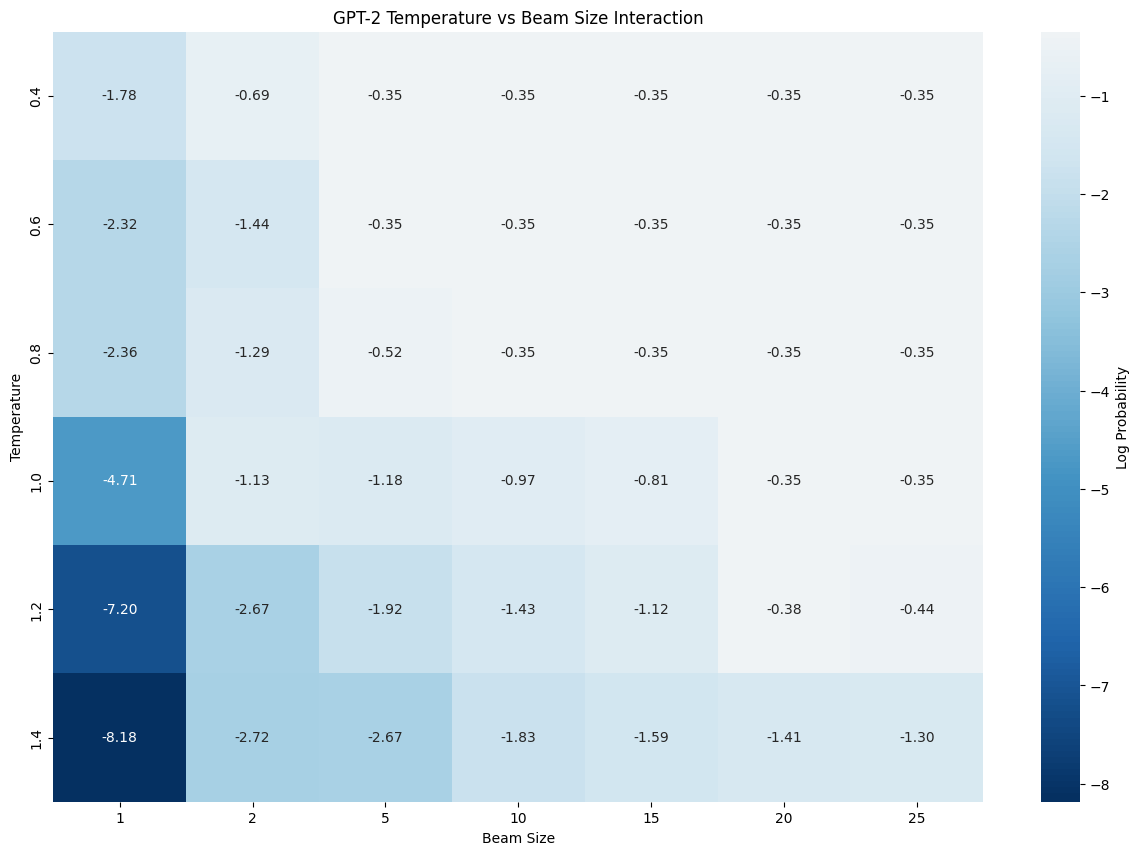


Best parameters found:
Temperature: 0.4
Beam Size: 10
Log Probability: -0.35


In [34]:
# Install required packages if not already installed
!pip install transformers

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
from typing import Dict, List
import pandas as pd
from tqdm.notebook import tqdm  # For Colab progress bars

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def sequence_logprob(model: GPT2LMHeadModel, sequence: torch.Tensor, input_len: int) -> float:
    """Calculate log probability of a sequence."""
    with torch.no_grad():
        outputs = model(sequence)
        logits = outputs.logits[:, input_len-1:-1, :]
        labels = sequence[:, input_len:]
        log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
        token_log_probs = log_probs.gather(-1, labels.unsqueeze(-1)).squeeze(-1)
        return token_log_probs.mean().item()

def grid_search_gpt2(
    model: GPT2LMHeadModel,
    tokenizer: GPT2Tokenizer,
    input_text: str,
    temperatures: List[float],
    beam_sizes: List[int],
    max_length: int = 50
) -> Dict:
    """
    Perform grid search over temperature and beam size parameters.
    """
    results = {}
    tokenized = tokenizer(input_text, return_tensors="pt").to(device)
    input_ids = tokenized["input_ids"]
    input_len = len(input_ids[0])

    # Calculate total iterations for progress bar
    total_iterations = len(temperatures) * len(beam_sizes)
    progress_bar = tqdm(total=total_iterations, desc="Grid Search Progress")

    # Grid search
    for temp in temperatures:
        results[temp] = {}
        for beam in beam_sizes:
            # Generate text with current parameters
            output = model.generate(
                **tokenized,
                pad_token_id=50256,
                max_length=max_length,
                do_sample=True,
                num_beams=beam,
                temperature=temp,
                top_k=0
            )

            # Calculate log probability
            logp = sequence_logprob(model, output, input_len)
            results[temp][beam] = logp

            # Update progress bar
            progress_bar.update(1)
            progress_bar.set_postfix({'Temp': temp, 'Beam': beam, 'LogProb': f'{logp:.2f}'})

    progress_bar.close()
    return results

def plot_heatmap(results: Dict, save_path: str = None):
    """
    Create and save a heatmap visualization of the results.
    """
    # Convert results to DataFrame
    temperatures = list(results.keys())
    beam_sizes = list(results[temperatures[0]].keys())

    data = []
    for temp in temperatures:
        for beam in beam_sizes:
            data.append({
                'Temperature': temp,
                'Beam Size': beam,
                'LogProb': results[temp][beam]
            })

    df = pd.DataFrame(data)
    pivot_table = df.pivot(index='Temperature', columns='Beam Size', values='LogProb')

    # Create heatmap with larger figure size for Colab
    plt.figure(figsize=(15, 10))
    sns.heatmap(
        pivot_table,
        annot=True,
        fmt='.2f',
        cmap='RdBu_r',
        center=0,
        cbar_kws={'label': 'Log Probability'}
    )

    plt.title('GPT-2 Temperature vs Beam Size Interaction')
    plt.xlabel('Beam Size')
    plt.ylabel('Temperature')

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

# Main execution
def main():
    # Initialize model and tokenizer
    print("Loading GPT-2 model and tokenizer...")
    model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    # Define parameter ranges
    temperatures = [0.4, 0.6, 0.8, 1.0, 1.2, 1.4]
    beam_sizes = [1, 2, 5, 10, 15, 20, 25]

    # Sample input text
    input_text = "The quick brown fox jumps over the lazy"

    print("\nStarting grid search...")
    # Perform grid search
    results = grid_search_gpt2(
        model=model,
        tokenizer=tokenizer,
        input_text=input_text,
        temperatures=temperatures,
        beam_sizes=beam_sizes
    )

    print("\nCreating visualization...")
    # Plot and save results
    plot_heatmap(results, save_path='gpt2_parameter_interaction.png')

    # Find and print best parameter combination
    best_temp = None
    best_beam = None
    best_logp = float('-inf')

    for temp in results:
        for beam in results[temp]:
            if results[temp][beam] > best_logp:
                best_logp = results[temp][beam]
                best_temp = temp
                best_beam = beam

    print(f"\nBest parameters found:")
    print(f"Temperature: {best_temp}")
    print(f"Beam Size: {best_beam}")
    print(f"Log Probability: {best_logp:.2f}")

# To run in Colab:
main()

## Exercise B

Now start with a new prompt in your own native language. Run (some of) the hyperparameter combinations as tested in Exercise A and earlier in this notebook.

What do you observe in terms of

*   Quality of the generated sequences
*   Logprob scores

Discuss what you observe.

In [33]:
max_length = 128
input_txt = """Er was eens een klein meisje, dat woonde in een dorpje \
in een groot bos. Iedereen hield van haar, omdat ze zo lief was.\n \
Moeder: Kijk eens, ik heb een nieuwe muts voor je gemaakt!\n \
Roodkapje: Mag ik hem meteen opzetten?\n \
Moeder: Direkt"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [35]:
output_nl = model.generate(input_ids, max_length=max_length, do_sample=True,
                                  num_beams=10, temperature=0.8, top_k=0)
logp = sequence_logprob(model, output_nl, input_len=len(input_ids[0]))
print(tokenizer.decode(output_nl[0]))
print(f"\nlog-prob: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Er was eens een klein meisje, dat woonde in een dorpje in een groot bos. Iedereen hield van haar, omdat ze zo lief was.
 Moeder: Kijk eens, ik heb een nieuwe muts voor je gemaakt!
 Roodkapje: Mag ik hem meteen opzetten?
 Moeder: Direkt een, ik heb een nieuwe muts voor je gemaakt!
Roodkapje:

log-prob: -0.67


The output seems to repeat anyhting you give it and then devolves to random gibberish when adjusting hyper peramters.